# Permutation feature importance for classifying heart beats using an LSTM

In [1]:
# Imports:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import os
import seaborn as sns
from sklearn import *
from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Flatten, MaxPooling1D, Dense
sns.set()

length = 277

### Load the holdout beats data and one-hot encode the heart beat classes

In [2]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('../../train_beats.csv')
test_beats = glob.glob('../../test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data, and one-hot encode Y:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]
y_train = train_values[:,-2]
y_test = test_values[:,-2]
X_train1 = X_train.reshape(-1, X_train.shape[1], 1)
X_test1 = X_test.reshape(-1, X_train.shape[1], 1)
y_train1=to_categorical(y_train)
y_test1=to_categorical(y_test)

# Combine everything again:
X = np.concatenate((X_train1, X_test1), axis = 0)
Y = np.concatenate((y_train1, y_test1), axis = 0)

Loading  ../../train_beats.csv
Loading  ../../test_beats.csv
(31912, 277)
(37863, 277)


### Build the LSTM architecture

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

def getlstmModel():
    lstmmodel = Sequential()
    lstmmodel.add(LSTM(128, return_sequences=True, input_shape=(X_train1.shape[1],X_train1.shape[2])))
    lstmmodel.add(LSTM(9, return_sequences=True))
    lstmmodel.add(MaxPooling1D(pool_size=4,padding='same'))
    lstmmodel.add(Flatten())
    lstmmodel.add(Dense(256, activation=tf.nn.relu))    
    lstmmodel.add(Dense(128, activation=tf.nn.relu))    
    lstmmodel.add(Dense(32, activation=tf.nn.relu))
    lstmmodel.add(Dense(9, activation='softmax'))
    lstmmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return lstmmodel

lstmmodel = getlstmModel()
lstmmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 275, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 275, 9)            4968      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 9)             0         
_________________________________________________________________
flatten (Flatten)            (None, 621)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               159232    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

### Implement and apply permutation feature importance

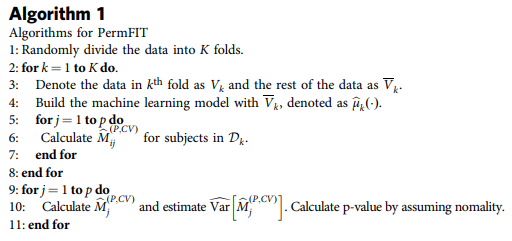

In [12]:
from IPython.display import Image
Image("../../algorithm_permutation_feature_importance.png")

__Perturbation methods:__ <br>
There are different types of perturbation possible for permutation feature importance, such as mean perturbation, zero perturbation, and random perturbation. They are shown in the plot below. In the implementation in this notebook, the data points within one slice are randomly shuffled. 

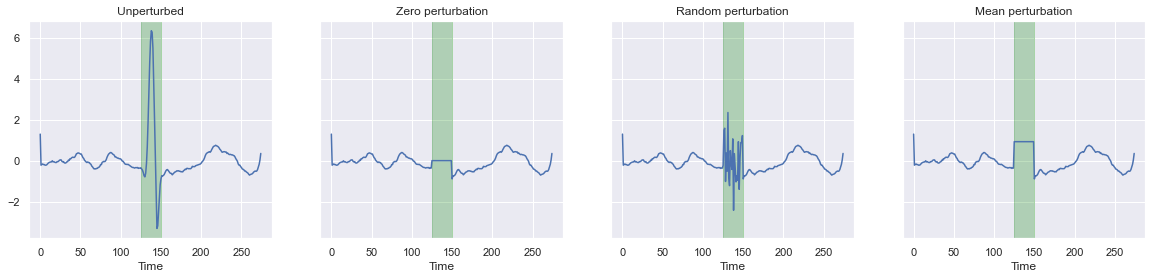

In [11]:
fig, ax = plt.subplots(1, 4, figsize = (20, 4), sharex = True, sharey=True)

# Unperturbed: the original signal.
ax[0].set_title('Unperturbed')
ax[0].plot(np.arange(len( X[20, :])), X[20, :])

# Zero perturbation: the values within the current slice are set to zero.
ax[1].set_title('Zero perturbation')
X_zero_perturbed = X[20, :].copy()
X_zero_perturbed[5 * 25 : 6 * 25] = 0.0
ax[1].plot(np.arange(len(X[20, :])), X_zero_perturbed)

# Random perturbation: the values within the current slice are replaced with random numbers.
ax[2].set_title('Random perturbation')
X_random_perturbed = X[20, :].copy()
X_random_perturbed[5 * 25 : 6 * 25] = np.std(X[20, :]) * np.random.randn(25, 1) + np.mean(X[20, :])
ax[2].plot(np.arange(len(X[20, :])), X_random_perturbed)

# Mean perturbation: the values within the current slice are averaged.
ax[3].set_title('Mean perturbation')
X_mean_perturbed = X[20, :].copy()
X_mean_perturbed[5 * 25 : 6 * 25] = np.mean(X[20, 5 * 25 : 6 * 25])
ax[3].plot(np.arange(len(X[20, :])), X_mean_perturbed)

for i in range(4):
    ax[i].set_xlabel('Time')
    ax[i].axvspan(5 * 25, 6 * 25, color = 'green', alpha = 0.25)
fig.savefig('perturbation_methods_ecg_data.jpg', dpi = 400)

In [5]:
# Permutation feature importance:
skf = StratifiedKFold(n_splits = 5, shuffle = True)
fold_counter = 0
M = np.zeros((X.shape[0], 11))
for train_index, test_index in skf.split(X, np.argmax(Y, axis = 1)):
    print('Fold ', fold_counter)
    
    # Split the data in this fold:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Build the machine learning model with the training data:
    lstmmodel = getlstmModel()
    lstmhistory = lstmmodel.fit(X_train, y_train, verbose = 0, epochs = 10, validation_split = 0.2, batch_size = 256)
    
    # Predict on the test fold without permutations:
    pred_k = lstmmodel.predict(X_test)     
    
    # For every feature:
    for slice_start in range(0, 275, 25):
        # Permute and predict:
        x_permuted = np.copy(X_test)
        x_slice = X_test[:, slice_start:slice_start+25]
        x_slice_permuted = np.random.permutation(x_slice)
        x_permuted[:, slice_start:slice_start + 25] = x_slice_permuted
        pred_perm = lstmmodel.predict(x_permuted)
    
        # Compute importance:
        importance = ((np.argmax(y_test, axis = 1) - np.argmax(pred_perm, axis = 1))**2 
                      - (np.argmax(y_test, axis = 1) - np.argmax(pred_k, axis = 1))**2)
        M[test_index, slice_start // 25] = importance 
    fold_counter += 1
mean_importance = np.mean(M, axis = 0)

Fold  0


C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Fold  1
Fold  2
Fold  3
Fold  4


In [ ]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(lstmmodel, 'lstmmodel_pfi_ecg.h5')

### Visualize the feature importances per slice

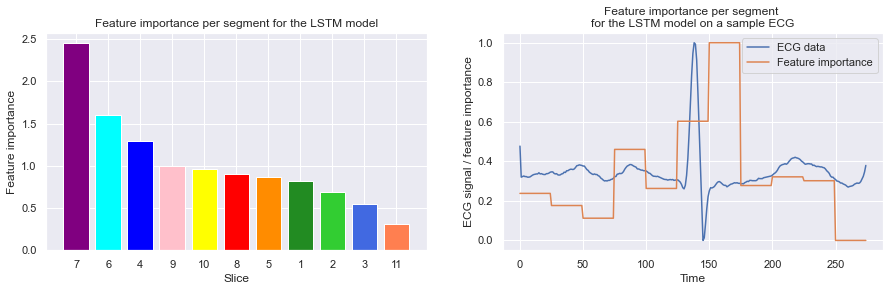

In [14]:
indices_sort = np.argsort(-1 * mean_importance)
slices = np.arange(1, 12)
colors = ['forestgreen', 'limegreen', 'royalblue', 'blue', 'darkorange', 'cyan', 'purple', 'red', 'pink', 'yellow', 'coral']

fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].bar(range(11), mean_importance[indices_sort], color = np.array(colors)[indices_sort])
ax[0].set_title('Feature importance per segment for the LSTM model')
ax[0].set_xticks(np.arange(11))
ax[0].set_xticklabels(slices[indices_sort].astype(int))
ax[0].set_xlabel('Slice')
ax[0].set_ylabel('Feature importance')

ecg_normalized = (X[20, :] - X[20, :].min()) / (X[20, :].max() - X[20, :].min())
feature_importance_normalized = (mean_importance - mean_importance.min()) / (mean_importance.max() - mean_importance.min())
ax[1].plot(np.arange(len(ecg_normalized)), ecg_normalized, label='ECG data')
ax[1].plot(np.repeat(feature_importance_normalized, 25), label = 'Feature importance')
ax[1].set_title('Feature importance per segment \nfor the LSTM model on a sample ECG')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('ECG signal / feature importance')
ax[1].legend()
fig.savefig('lstm_permutation_feature_importance_results.jpg', dpi = 400)